In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import bayesflow as bf

In [3]:
np.set_printoptions(suppress=True)

RNG = np.random.default_rng(1069)

In [4]:
N_OBS = 4000
(DISP_X, DISP_Y) = (2560, 1080)
PARAM_NAMES = [r"$\mu$", r"$\sigma$"]

Brute-force simulation to make sure that this is not stupid.

<Axes: >

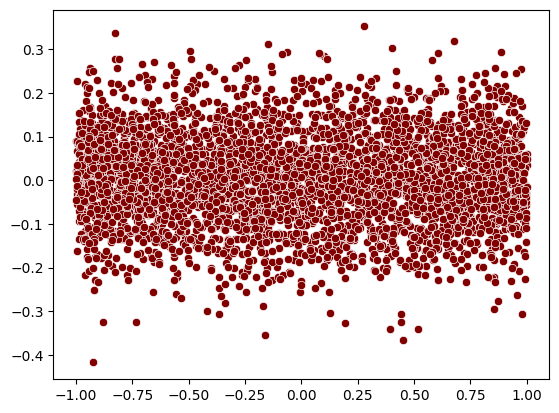

In [5]:
y = RNG.normal(0., 0.1, size=N_OBS)
x = RNG.uniform(-1., 1., size=N_OBS)

sns.scatterplot(x=x, y=y, color='maroon')

Properly-defined prior and simulator for BayesFlow.

In [6]:
def prior_fun(rng=None):
    """
    Generate prior parameters for vertical gaze distribution.
    """
    if rng is None:
        rng = np.random.default_rng()

    mu = rng.normal(0, 1)
    sigma = rng.gamma(2, 2)

    theta = np.array([mu, sigma])

    return theta

In [7]:
def gaze_simulator_fun(theta, N_OBS=100, rng=None):

    mu, sigma = theta

    if rng is None:
        rng = np.random.default_rng()


    x = rng.uniform(-1., 1., size=N_OBS)
    y = rng.normal(mu, sigma, size=N_OBS)

    gaze_xy = np.array([x, y])
    return gaze_xy

Again simulating in brute force.

<Axes: >

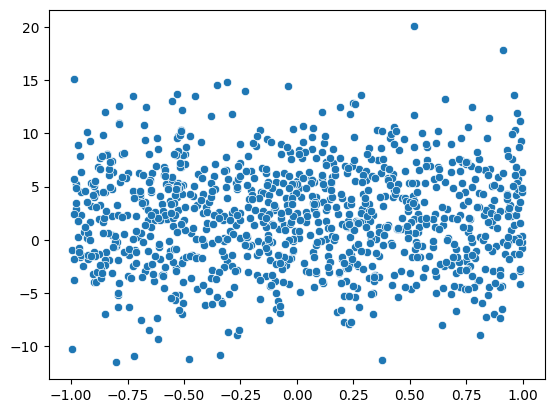

In [8]:
theta = prior_fun()
gaze_xy = gaze_simulator_fun(theta, N_OBS=1000)

sns.scatterplot(x=gaze_xy[0], y=gaze_xy[1])

Wrapping them up with `bf.simulation`.

In [9]:
prior = bf.simulation.Prior(prior_fun=prior_fun, param_names=PARAM_NAMES)

Prior predictive check

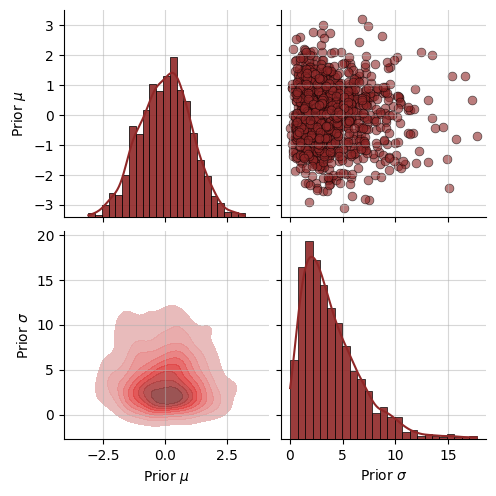

In [10]:
# Prior predictive check
f = bf.diagnostics.plot_prior2d(prior=prior, n_samples=1000, param_names=PARAM_NAMES)

### Generative Model

In [11]:
model = bf.simulation.GenerativeModel(
    prior=prior,
    simulator=gaze_simulator_fun,
    name="gaze",
    simulator_is_batched=False
)

INFO:root:Performing 2 pilot runs with the gaze model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2, 100)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [12]:
sim = model(100)

In [13]:
sim

{'prior_non_batchable_context': None,
 'prior_batchable_context': None,
 'prior_draws': array([[ 0.00738353,  3.98126095],
        [ 1.25941598,  2.31085436],
        [-0.1418099 ,  7.59273233],
        [-0.99611547,  4.19621269],
        [-1.86647161,  2.2997318 ],
        [ 0.46478687,  2.59503607],
        [ 0.07978252,  6.30696057],
        [ 0.06892619,  1.45589346],
        [-0.50463416,  5.94841968],
        [ 0.93088107,  2.67105347],
        [-0.81591823,  5.08062421],
        [ 0.89459927,  0.50167533],
        [-0.45309161,  3.74387794],
        [ 1.18256358,  3.92924571],
        [ 0.10193588, 12.06771945],
        [-1.8228778 ,  1.67476101],
        [ 0.95263737,  0.65230576],
        [ 0.35242309,  2.27764892],
        [-1.89918469,  3.43676638],
        [-0.96327644,  4.71797686],
        [-0.18470709,  8.05477579],
        [ 0.30304676,  8.87652674],
        [ 0.70185876,  2.62103414],
        [ 0.24019038,  1.32078288],
        [-0.63110698,  1.51653946],
        [-0.3

### Neural Approximator

In [14]:
summary_net = bf.summary_networks.DeepSet()

2024-04-20 22:51:55.184748: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-20 22:51:55.185247: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [16]:
inference_net = bf.inference_networks.InvertibleNetwork(num_params=len(PARAM_NAMES))

In [17]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

In [19]:
def configurator(forward_dict):
    out_dict = {}

    out_dict["parameters"] = forward_dict["prior_draws"]
    out_dict["summary_conditions"] = forward_dict["sim_data"]

    return out_dict

In [20]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [21]:
amortizer.summary()

Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  436296    
 ibleNetwork)                                                    
                                                                 
 deep_set (DeepSet)          multiple                  80010     
                                                                 
Total params: 516306 (1.97 MB)
Trainable params: 516282 (1.97 MB)
Non-trainable params: 24 (96.00 Byte)
_________________________________________________________________


In [22]:
losses = trainer.train_online(epochs=10, iterations_per_epoch=100, batch_size=32)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

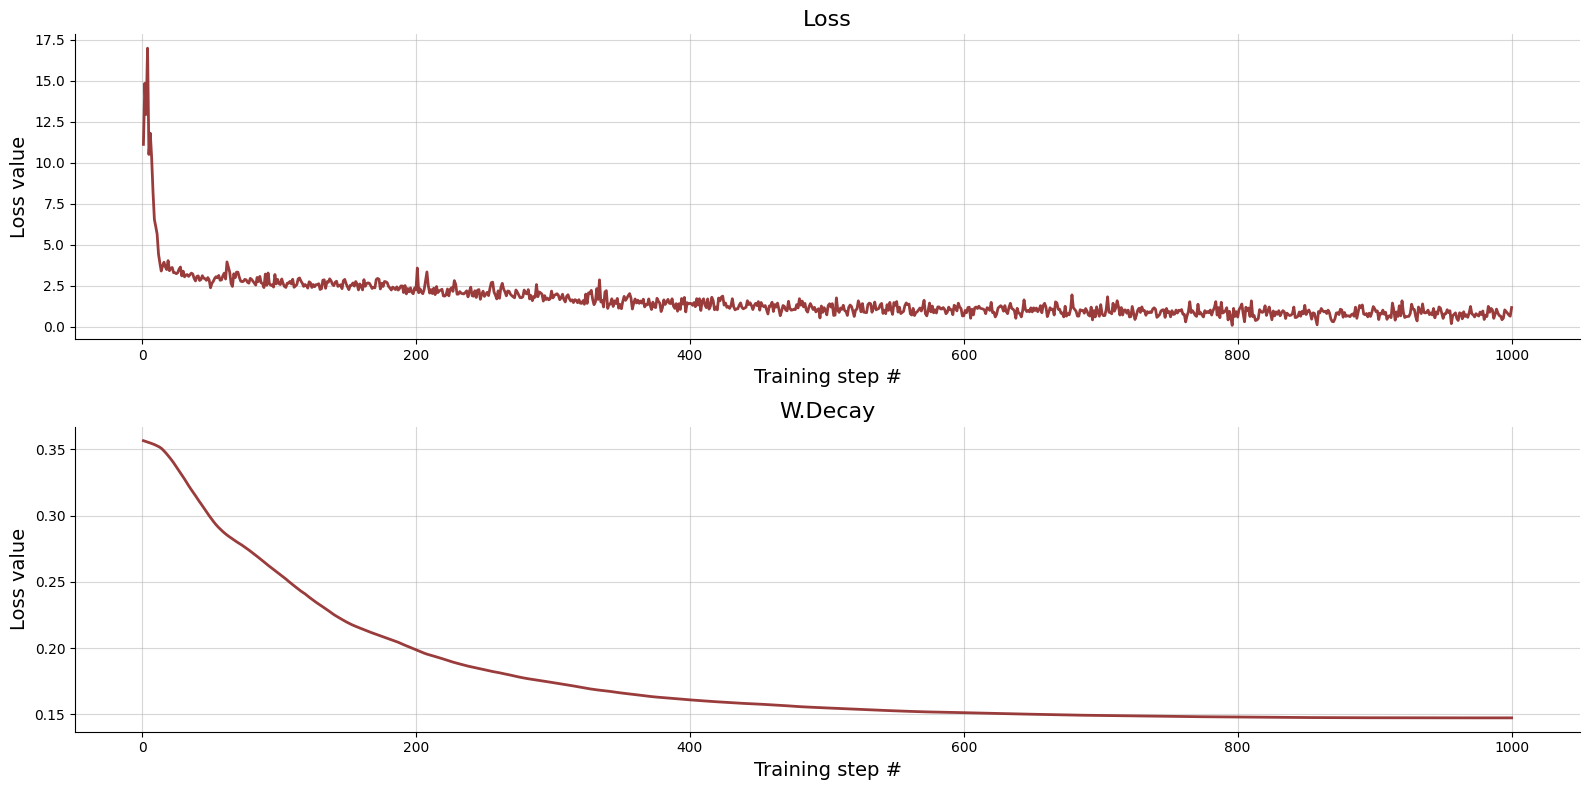

In [23]:
f = bf.diagnostics.plot_losses(losses)

In [30]:
## Parameter recovery
resim = configurator(model(500))

In [35]:
post_samples = amortizer.sample(resim, n_samples=1000)
post_samples.shape

(500, 1000, 2)

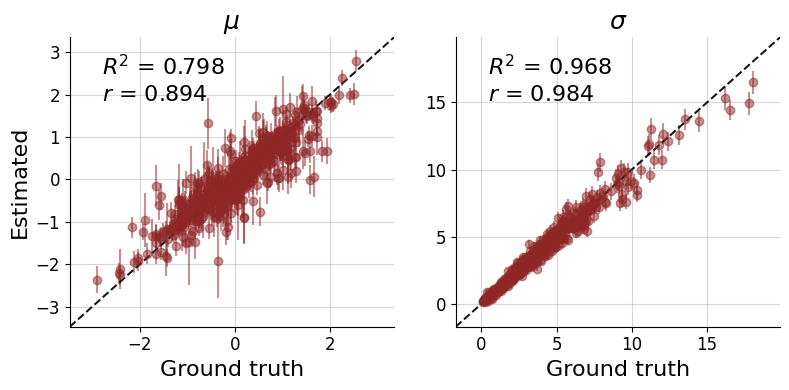

In [36]:
f = bf.diagnostics.plot_recovery(post_samples, resim['parameters'], param_names=PARAM_NAMES)

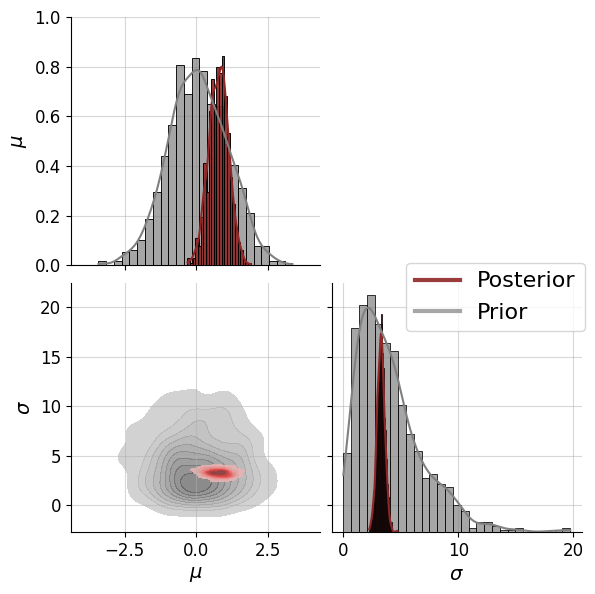

In [37]:
f = bf.diagnostics.plot_posterior_2d(post_samples[0], prior=prior)

<Axes: >

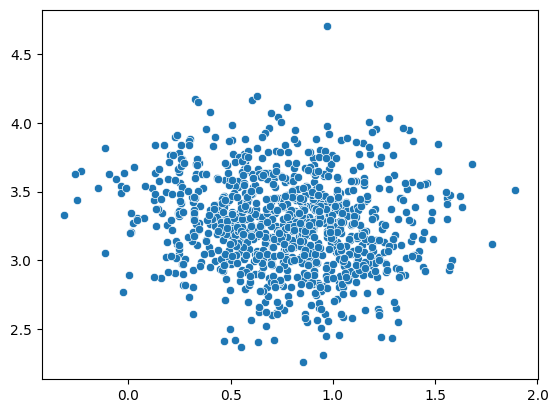

In [40]:
samples = post_samples[0]
sns.scatterplot(x=samples[:,0], y=samples[:,1])